# Food Access in Houston, TX, USA
#### Adonis Ichim, June 27th, 2020

## Introduction 

The City of Houston, Texas, USA is the fourth most populous city in the United States with an estimated 2019 population of 2,320,268. The Houston metropolitan area spans over 1,062 square miles (or 2,750 square kilometers), and is home to more than 6.9 million residents. Houston's economy has a broad base in energy, healthcare, manufacturing, aeronautics, and transportation. Houston is a majority-minority city, with a vibrant, ethnically and culturally diverse community. The city boasts more than 10,000 restaurants, bars, and supporting businesses. 


Because of the city's large surface area, limited options of efficient public transportation, zoning laws, and income variability, some zones may not provide adequate food access to the population. According to USDA 2014 data, Houston had 0.17 grocery stores per 1,000 people. Lack of a suitable food supply in the vicinity of one's home can lead to health issues, additional costs and longer times to purchase food. This may also represent lost revenue for the city and the food supply chain. 

I will explore what those zones are today and provide solutions to decrease the number of residents living in a food desert. The outcomes of this project should help investors decide where to build food stores and city officials to understand problematic zones where they could intervene with additional support.


## Data 

To determine zones with unsatisfactory food access, I will leverage Foursquare's API and access geospatial data. The venue categories I will focus on are: 
* grocery store, 
* supermarket, 
* market, 
* farmers market, 
* food & drink shop.

I will combine this with Census data, centralized and published by Houston State of Health. The census data pertains to: 
* income, 
* living cost, 
* internet and vehicle availability, 

and will enable our understanding of what type of food venue one may consider for a specific location. 
Data will be analyzed by Postal Code, which will increase the granularity of the analysis.

### Census Data

In [1]:
# import useful libraries 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import types
from botocore.client import Config
import ibm_boto3

print ('Libraries have been imported.')

Libraries have been imported.


I have downloaded the data from houstonstateofhealth.com and uploaded it in the IBM Cloud environment.
Next, I will load each .csv file into separate data frames.


In [2]:
# The code was removed by Watson Studio for sharing.

,Indicator Name,What Is This Indicator,Location Type,Location,Indicator Rate Value,Indicator Rate Value Units,Rate Lower Confidence Interval,Rate Upper Confidence Interval,Indicator Count Value,Indicator Count Value Units,...,Breakout Rate Value,Breakout Rate Value Units,Breakout Rate Lower Confidence Interval,Breakout Rate Upper Confidence Interval,Breakout Count Value,Breakout Count Value Units,Breakout Count Lower Confidence Interval,Breakout Count Upper Confidence Interval,Breakout Unstable,Breakout Footer
0,Homeownership,This indicator shows the percentage of all hou...,Zip Code,77002,15.6,percent,11.8,19.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Homeownership,This indicator shows the percentage of all hou...,Zip Code,77002,19.7,percent,16.0,23.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As seen in the above dataframe, there are lots of columns without values and some that are not useful for our analysis. For each dataframe we will only keep useful columns such as Location (Zip Code) and Indicator Rate Value.

In [3]:
#first, drop all columns with NaN values in all dataframes
df_rent = df_rent.dropna(axis='columns')
df_nocar = df_nocar.dropna(axis='columns')
df_internet = df_internet.dropna(axis='columns')
df_income = df_income.dropna(axis='columns')
df_poverty = df_poverty.dropna(axis='columns')
df_homeown = df_homeown.dropna(axis='columns')

In [4]:
# the plan is to combine all dataframes into one, so we rename the columns for later when we combine the dataframes
df_rent.columns = ['Indicator Name', 'Indicator Description', 'Location Type', 'Postal Code', 'Median Rent ($)', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source']
df_nocar.columns =  ['Indicator Name', 'Indicator Description', 'Location Type', 'Postal Code', 'Households wihout vehicle (%)', 'Unit', 'Unstable', 'Period', 'Source']
df_internet.columns =  ['Indicator Name', 'Indicator Description', 'Location Type', 'Postal Code', 'Households with internet (%)', 'Unit', 'Unstable', 'Period', 'Source']
df_income.columns = ['Indicator Name', 'Indicator Description', 'Location Type', 'Postal Code', 'Per Capita Income ($)', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source']
df_poverty.columns = ['Indicator Name', 'Indicator Description', 'Location Type', 'Postal Code', 'Households below poverty level (%)', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source']
df_homeown.columns = ['Indicator Name', 'Indicator Description', 'Location Type', 'Postal Code', 'Homeownership (%)', 'Unit', 'Unstable', 'Period', 'Source']


In [5]:
#some of the columns are redundant, so we will drop 'Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source' where available

df_rent = df_rent.drop(['Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source'], axis=1)
df_nocar = df_nocar.drop(['Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Unstable', 'Period', 'Source'], axis=1)
df_internet = df_internet.drop(['Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Unstable', 'Period', 'Source'], axis=1)
df_income = df_income.drop(['Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source'], axis=1)
df_poverty = df_poverty.drop(['Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Unstable', 'Period', 'Source'], axis=1)
df_homeown = df_homeown.drop(['Indicator Name', 'Indicator Description', 'Location Type', 'Unit', 'Unstable', 'Period', 'Source'], axis=1)

In [6]:
#checking one of the df
df_internet.head()

,Postal Code,Households with internet (%)
0,77002,84.4
1,77002,81.1
2,77003,81.8
3,77003,76.9
4,77004,74.7


In [7]:
# we group the data in each dataframe by Zip Code and use average in case there are multiple reported values for one Zip Code
df_rent=df_rent.groupby('Postal Code').mean().reset_index()
df_nocar=df_nocar.groupby('Postal Code').mean().reset_index()
df_internet=df_internet.groupby('Postal Code').mean().reset_index()
df_income=df_income.groupby('Postal Code').mean().reset_index()
df_poverty=df_poverty.groupby('Postal Code').mean().reset_index()
df_homeown=df_homeown.groupby('Postal Code').mean().reset_index()
#resulting in 6 dataframes of 2 columns and 130 rows each

In [8]:
# we combine the dataframes in a new one called df_census

df_census=pd.merge(df_rent, df_nocar, on='Postal Code')
df_census=pd.merge(df_census, df_internet, on='Postal Code')
df_census=pd.merge(df_census, df_income, on='Postal Code')
df_census=pd.merge(df_census, df_poverty, on='Postal Code')
df_census=pd.merge(df_census, df_homeown, on='Postal Code')


In [9]:
df_census.head()

,Postal Code,Median Rent ($),Households wihout vehicle (%),Households with internet (%),Per Capita Income ($),Households below poverty level (%),Homeownership (%)
0,77002,1401.666667,17.6750,82.75,34888.500,9.0250,17.8250
1,77003,1008.666667,16.3875,79.35,31134.125,33.3375,33.3500
2,77004,946.666667,20.6000,73.85,30638.000,19.7625,25.2625
3,77005,1713.333333,3.9875,94.45,94654.500,1.5625,66.8625
4,77006,1260.666667,7.2500,87.30,64342.625,3.2625,31.2875


In [10]:
#not sure what happened to the index while merging above, specify 'Postal Code' as index again
df_census=df_census.set_index('Postal Code')

In [11]:
df_census.shape

(130, 6)

The df_census dataframe puts together the data from 6 different sources and groups it by Postal Code. There are 130 entries.

### Postal Codes Coordinates

I will get the US Postal Codes Coordinates from the public dataset stored at https://public.opendatasoft.com/.

In [12]:
!wget -q -O 'TX_ZipCodes.csv'  "https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=TX&timezone=America/Chicago&lang=en&use_labels_for_header=true&csv_separator=%3B"
df_zip = pd.read_csv('TX_ZipCodes.csv', sep=';', engine='python')

In [13]:
df_zip.head(5)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,75475,Randolph,TX,33.485315,-96.25525,-6,1,"33.485315,-96.25525"
1,75757,Bullard,TX,32.136787,-95.36710,-6,1,"32.136787,-95.3671"
2,78650,McDade,TX,30.283941,-97.23563,-6,1,"30.283941,-97.23563"
3,75010,Carrollton,TX,33.030556,-96.89328,-6,1,"33.030556,-96.89328"
4,76054,Hurst,TX,32.858398,-97.17681,-6,1,"32.858398,-97.17681"


In [14]:
df_zip.shape

(2743, 8)

In [15]:
#put Houston, TX entries in a separate dataframe, rename columns, drop last three columns and set Postal Code as Index
df_zip = df_zip.drop(['Timezone', 'Daylight savings time flag', 'geopoint'], axis=1)
df_zip_HTX=df_zip[df_zip['City'].str.match('Houston')]
df_zip_HTX=df_zip_HTX.drop(['City', 'State'], axis=1)
df_zip_HTX.columns=['Postal Code', 'Latitude', 'Longitude']
df_zip_HTX=df_zip_HTX.set_index('Postal Code')

In [16]:
#Now we have one dataframe with the latitude and longitude of Postal Codes in Houston, TX. This will be useful in the next step
df_zip_HTX.head()

,Latitude,Longitude
Postal Code,,
77046,29.733181,-95.431310
77015,29.778526,-95.181180
77289,29.833990,-95.434241
77072,29.700898,-95.590020
77216,29.833990,-95.434241


In [17]:
df_zip_HTX.shape

(182, 2)

In [18]:
#merge the df above with the census data frame
df_census_zip=pd.merge(df_census, df_zip_HTX, on='Postal Code')

In [19]:
df_census_zip.head()

,Median Rent ($),Households wihout vehicle (%),Households with internet (%),Per Capita Income ($),Households below poverty level (%),Homeownership (%),Latitude,Longitude
Postal Code,,,,,,,,
77002,1401.666667,17.6750,82.75,34888.500,9.0250,17.8250,29.755578,-95.36531
77003,1008.666667,16.3875,79.35,31134.125,33.3375,33.3500,29.749278,-95.34741
77004,946.666667,20.6000,73.85,30638.000,19.7625,25.2625,29.728779,-95.36570
77005,1713.333333,3.9875,94.45,94654.500,1.5625,66.8625,29.717529,-95.42821
77006,1260.666667,7.2500,87.30,64342.625,3.2625,31.2875,29.741878,-95.38944


In [20]:
df_census_zip.reset_index(inplace=True)

In [21]:
df_census_zip.columns

Index(['Postal Code', 'Median Rent ($)', 'Households wihout vehicle (%)',
       'Households with internet (%)', 'Per Capita Income ($)',
       'Households below poverty level (%)', 'Homeownership (%)', 'Latitude',
       'Longitude'],
      dtype='object')

In [22]:
df_census_zip.shape

(95, 9)

It seems we lost some entries. This is ok, as the initial dataset may have included Postal Codes from the Houston Metro area, and not necessarily from the City of Houston. This should help us narrow down the scope of our work.

### Geospatial Data

In [23]:
#we need some additional libraries for this step

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip -q install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [24]:
#get city coordinates by using geolocator
address = 'Houston, TX'

geolocator = Nominatim(user_agent="Houston")
location = geolocator.geocode(address)
lat = location.latitude
lon = location.longitude
print('The coordinates of Houston are {}, {}.'.format(lat, lon))

The coordinates of Houston are 29.7589382, -95.3676974.


In [25]:

#create map
map_htx = folium.Map(location=[lat, lon], zoom_start=10)

# add markers to map
for post, lat, lng in zip(df_census_zip['Postal Code'], df_census_zip['Latitude'], df_census_zip['Longitude']):
    label = '{}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_htx)  
    
map_htx

So now we have the Postal Codes of Houston, TX on the city map. Next, I will use the Foursquare API to obtain data on specific venue types.

### Foursquare API Data

In [26]:
# The code was removed by Watson Studio for sharing.

In [27]:
#radius and limit
radius=3000
LIMIT=200
#categoryID
categoryID= '4bf58dd8d48988d118951735'
#search query
search_query=''

#the category IDs are accessible at https://developer.foursquare.com/docs/build-with-foursquare/categories/
#for grocery stores, I chose to work with "Supermarkets", there are other IDs that may fall within this classification such as:
#4bf58dd8d48988d118951735 - grocery store
#52f2ab2ebcbc57f1066b8b45 - organic grocery 
#4bf58dd8d48988d1f9941735 - food and drink shop
#52f2ab2ebcbc57f1066b8b46 - supermarket

In [28]:
def getNearbyVenues(names, latitudes, longitudes, categoryIds=categoryID, search_query=search_query):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)
            if (search_query != ''):
                url = url + '&query={}'
                url = url.format(search_query)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [29]:
houston_venues = getNearbyVenues(names=df_census_zip['Postal Code'],
                                   latitudes=df_census_zip['Latitude'],
                                   longitudes=df_census_zip['Longitude']
                                  )

In [30]:
houston_venues.columns = ['Postal Code', 
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                 ]

In [31]:
houston_venues.head(10)

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,77002,29.755578,-95.36531,A&K Sammis Convenient & Gift Store,29.755707,-95.364785,Grocery Store
1,77002,29.755578,-95.36531,Whole Foods Market,29.744379,-95.381412,Grocery Store
2,77002,29.755578,-95.36531,D J Super Market,29.744470,-95.332044,Grocery Store
3,77002,29.755578,-95.36531,Grit Grocery,29.761934,-95.362135,Food Truck
4,77002,29.755578,-95.36531,Midtown Food Store,29.749687,-95.377785,Grocery Store
5,77002,29.755578,-95.36531,Kim Hung Market,29.750712,-95.355355,Grocery Store
6,77002,29.755578,-95.36531,1st Stop Convenience Store,29.742616,-95.388596,Grocery Store
7,77002,29.755578,-95.36531,Sunny's Food Store,29.747130,-95.381287,Grocery Store
8,77002,29.755578,-95.36531,NuWaters Co-Operative,29.734398,-95.365256,Grocery Store
9,77002,29.755578,-95.36531,Sunrise Grocery,29.781233,-95.372794,Grocery Store


In [32]:
houston_venues.shape

(1182, 7)

In [33]:
from folium import plugins

In [34]:
# instantiate a mark cluster object for the incidents in the dataframe
food_stores = plugins.MarkerCluster().add_to(map_htx)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(houston_venues['Venue Latitude'], houston_venues['Venue Longitude'], houston_venues['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(food_stores)

# display map
map_htx

It looks like at certain latitude and longitude coordinates there are some duplicate entries. Check and make sure that's not the case.

In [35]:
houston_venues_dup = houston_venues[houston_venues.duplicated(subset=['Venue Latitude','Venue Longitude'], keep=False)]

In [36]:
houston_venues_dup.shape

(1042, 7)

There were 150 duplicate coordinates which were removed. Let's refresh the map with the new dataset.

In [37]:
#create map
map_htx = folium.Map(location=[lat, lon], zoom_start=10)

# add markers to map
for post, lat, lng in zip(df_census_zip['Postal Code'], df_census_zip['Latitude'], df_census_zip['Longitude']):
    label = '{}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_htx)  
    
food_stores = plugins.MarkerCluster().add_to(map_htx)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(houston_venues_dup['Venue Latitude'], houston_venues_dup['Venue Longitude'], houston_venues_dup['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(food_stores)

# display map
map_htx

Now that we obtained the data on grocery stores in Houston, TX, we can proceed to the next step of our analysis.

## Methodology

### Exploratory Statistics

First, explore the Census dataset that I compiled earlier.

In [38]:
df_census_zip.describe()

,Postal Code,Median Rent ($),Households wihout vehicle (%),Households with internet (%),Per Capita Income ($),Households below poverty level (%),Homeownership (%),Latitude,Longitude
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,77049.968421,1036.143860,8.506447,75.815789,32426.807895,17.338289,45.036447,29.777284,-95.415916
std,28.476737,342.298822,5.271014,13.004265,26838.304217,9.907849,16.547438,0.110309,0.129933
min,77002.000000,643.000000,0.775000,45.900000,11206.000000,1.562500,4.362500,29.552830,-95.698800
25%,77025.500000,832.000000,4.856250,66.625000,16005.000000,8.943750,33.675000,29.693796,-95.504275
50%,77049.000000,924.666667,7.250000,78.750000,21363.750000,17.850000,45.900000,29.755578,-95.414050
75%,77074.500000,1160.666667,11.312500,85.475000,36263.000000,23.931250,56.206250,29.857766,-95.337220
max,77099.000000,3154.000000,26.000000,98.050000,188382.250000,40.062500,91.537500,30.012711,-95.102650


It looks like for the 95 Postal Codes analyzed, the mean of the Median Rent is around 1,035 USD and the average per capita income is 33,400 USD. About 8.5% of the households do not have an internet connection, 17.33% find themselves below poverty level, and 75.82% have an internet connection.

In the venues dataset, there are 1042 entries, with 794 venues labelled as Grocery Store, 136 as Supermarket, and 30 as Big Box Store. There are some other ones in there like Convenience Store, Fish Market which may sell grocery items, so I will include these in the analysis.

In [39]:
houston_venues_dup.groupby('Venue Category').count()

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Arcade,3,3,3,3,3,3
Big Box Store,30,30,30,30,30,30
Butcher,2,2,2,2,2,2
Coffee Shop,7,7,7,7,7,7
Convenience Store,14,14,14,14,14,14
Discount Store,6,6,6,6,6,6
Fish Market,2,2,2,2,2,2
Food & Drink Shop,7,7,7,7,7,7
Food Truck,4,4,4,4,4,4


In [40]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [41]:
stores = houston_venues_dup.groupby('Venue Category', axis=0).count().sort_values(by='Venue', ascending=False)

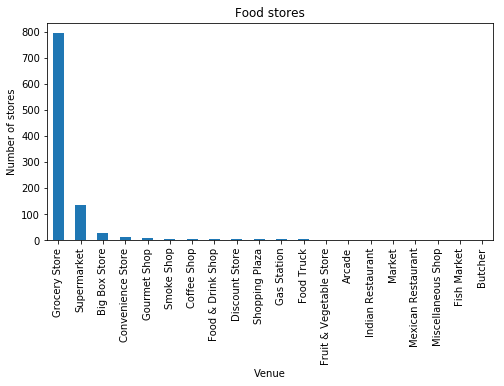

In [42]:
stores['Venue'].plot(kind='bar', figsize=(8, 4))

plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Number of stores') # add y-label to the plot
plt.title('Food stores') # add title to the plot

plt.show()

Next, we will explore the number of stores per postal code.

In [43]:
venues_zip_count=pd.DataFrame(houston_venues.groupby('Postal Code').count()['Venue'].sort_values(ascending=False))

In [44]:
venues_zip_count.columns=['Number of Stores']
venues_zip_count.reset_index(drop=False)

,Postal Code,Number of Stores
0,77081,32
1,77019,31
2,77007,30
3,77036,29
4,77057,28
5,77004,27
6,77098,26
7,77046,26
8,77096,25
9,77074,25


In [45]:
venues_zip_count.shape

(92, 1)

We see that Postal Code 77081 has 32 grocery stores, while some other postal codes have less than 5.

## Census Data Clustering

In this part, I will use K-Means Clustering to partition my census dataset into K pre-defined distinct and non-overlapping subgroups and gain insights about the population of each postal code.

In [46]:
# import k-means from clustering stage and StandardScaler from preprocessing stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

First, normalize the Census dataset to help algorithms interpret features with different magnitudes and distributions equally. Use StandardScaler() to normalize the dataset.

In [47]:
#df_census_zip=df_census_zip.set_index('Postal Code')

In [48]:
#drop latitude and longitude as these are not useful in the clustering algorithm
df_census_zip2 = df_census_zip.set_index('Postal Code').drop(['Latitude', 'Longitude'], axis=1)

In [49]:
#put the values in a np array
X = df_census_zip2.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
#Clus_dataSet

In [50]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[2 2 2 0 4 0 4 2 3 1 1 1 1 1 1 1 2 0 1 1 1 1 0 4 1 0 1 1 4 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 1 0 1 1 1 1 1 2 2 0 4 2 4 1 1 2 2 2 2 1 1 2 4 2 1 1 1 1 1 1 2
 1 4 1 1 2 1 2 1 1 1 1 1 1 1 1 1 4 2 2 0 1]


In [51]:
df_census_zip2.shape

(95, 6)

In [52]:
df_census_zip2["Cluster"] = labels
df_census_zip["Cluster"] = labels

I will add the Cluster Label to the Postal Code marker.

In [53]:
for post, lat, lng, cl, store in zip(df_census_zip['Postal Code'], df_census_zip['Latitude'], df_census_zip['Longitude'], df_census_zip['Cluster'], venues_zip_count['Number of Stores']):
    label = 'Postal Code {} is in Cluster {}. There are {} stores in it.'.format(post,cl,store)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_htx)  

## Results 

In [54]:
df_census_zip2.groupby('Cluster').mean().sort_values(by=['Per Capita Income ($)'])

,Median Rent ($),Households wihout vehicle (%),Households with internet (%),Per Capita Income ($),Households below poverty level (%),Homeownership (%)
Cluster,,,,,,
1,849.528302,10.442925,67.488679,16815.528302,23.612500,44.721226
2,1071.902778,7.006771,83.495833,33270.895833,12.864583,45.350521
4,1320.407407,4.701389,89.277778,57155.888889,6.094444,52.537500
0,1580.666667,4.904688,90.600000,86004.625000,3.651562,42.828125
3,3154.000000,4.925000,93.400000,188382.250000,2.862500,4.362500


We can observe a few trends from this clustering:
- Cluster 0 has the lowest Per Capita Income, Median Rent Value and Internet Subscriptions. 23.6% of the households live below the poverty level, and ~45% own their homes.
- Cluster 2 has a higher Per Capita Income and Median Rent,Internet usage above 80%. 12.86% of the households in these postal codes live below the poverty level, and 43.5% own their homes.
- Cluster 4 has a higher Per Capita Income and Median Rent,Internet usage close to 90%. 6% of the households in these postal codes live below the poverty level, and homeownership is at 52.5%.
- Cluster 1 has a higher Per Capita Income and Median Rent,Internet usage close to 90%. 3.65% of the households in these postal codes live below the poverty level, and homeownership is at 42.8%.
- Cluster 3 seems to be an outlier. Here, Per capita income is 120% higher than in Cluster 1 Postal Codes. Rent is also much higher. Internet usage is above 90% and homeownership is low, as well as the percentage of households below poverty level.

We visualize the trends in the following 2D and 3D plots.

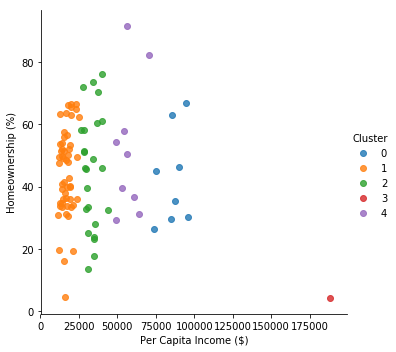

In [55]:
facet = sns.lmplot(data=df_census_zip2, x='Per Capita Income ($)', y='Homeownership (%)', hue='Cluster', 
                   fit_reg=False, legend=True, legend_out=True)

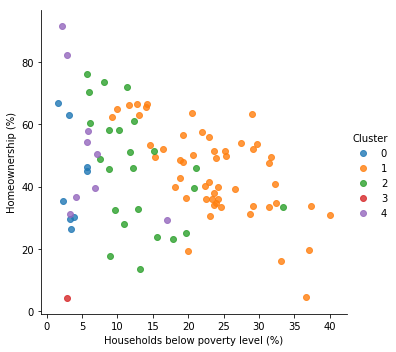

In [56]:
facet = sns.lmplot(data=df_census_zip2, x='Households below poverty level (%)', y='Homeownership (%)', hue='Cluster', 
                   fit_reg=False, legend=True, legend_out=True)

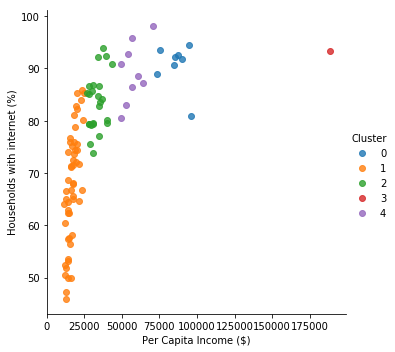

In [57]:
facet = sns.lmplot(data=df_census_zip2, x='Per Capita Income ($)', y='Households with internet (%)', hue='Cluster', 
                   fit_reg=False, legend=True, legend_out=True)

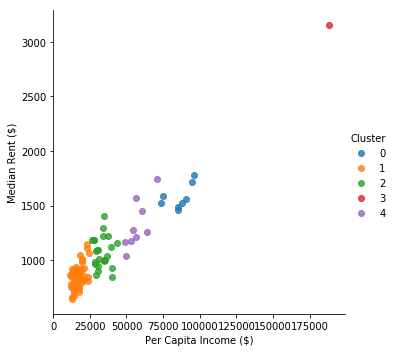

In [58]:
facet = sns.lmplot(data=df_census_zip2, x='Per Capita Income ($)', y='Median Rent ($)', hue='Cluster', 
                   fit_reg=False, legend=True, legend_out=True)

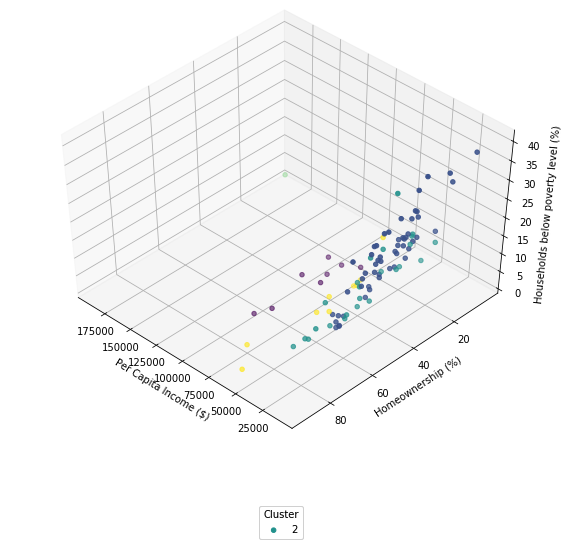

In [59]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

ax.set_xlabel('Per Capita Income ($)')
ax.set_ylabel('Homeownership (%)')
ax.set_zlabel('Households below poverty level (%)')

ax.scatter(df_census_zip2['Per Capita Income ($)'], df_census_zip2['Homeownership (%)'], df_census_zip2['Households below poverty level (%)'], c= df_census_zip2['Cluster'])
legend = ax.legend(df_census_zip2['Cluster'], loc="lower center", title="Cluster", borderaxespad=-10, ncol=4)
ax.add_artist(legend)


Finally, we display everything in one map, which allows seamless data exploration for the City of Houston.

In [60]:
map_htx

## Discussion

Based on these results, it is clear that the areas further away from the city center offer less food access. Investors can further explore these areas and consider the economic indicators clusters to decide if they would want to open a certain type of store in a specific location.

## Conclusions

“Food deserts” are a real issue even in large cities across the United States. Through accessing data and leveraging machine learning capabilities, I was able to draw conclusions on which areas seem to be impacted mostly by lack of food access, and how one may categorize these areas based on census economic indicators. I suggested a few ideas to improve food access such as opening smaller cost-saving stores in some lower income areas or using internet-enabled services in others. 

## References

1.	www.stateofhoustonhealth.com
2.	www.public.opendatasoft.com
3.	www.developer.foursquare.com/docs/build-with-foursquare/categories/
4.	www.communityimpact.com (Picture Credit)